## SVM with SMO.

In this notebook I'm planning to build the SVM model using the SMO algorithm. I'll break down the process to the following steps:
* SVM using SMO for the linearly seperable case.
* SVM using SMO for the non seperable case.
* Integrating Kernels into the model. 
* Benchmark the final model against the vanilla SVM in CS231 on the CIFAR dataset.

For each bullet point I'll create some visualization to help us better understand what the model is doing. To begin with the linearly seperable case I will look at the Iris dataset and I'm going to make sure that the data is in fact linearly seperable. 

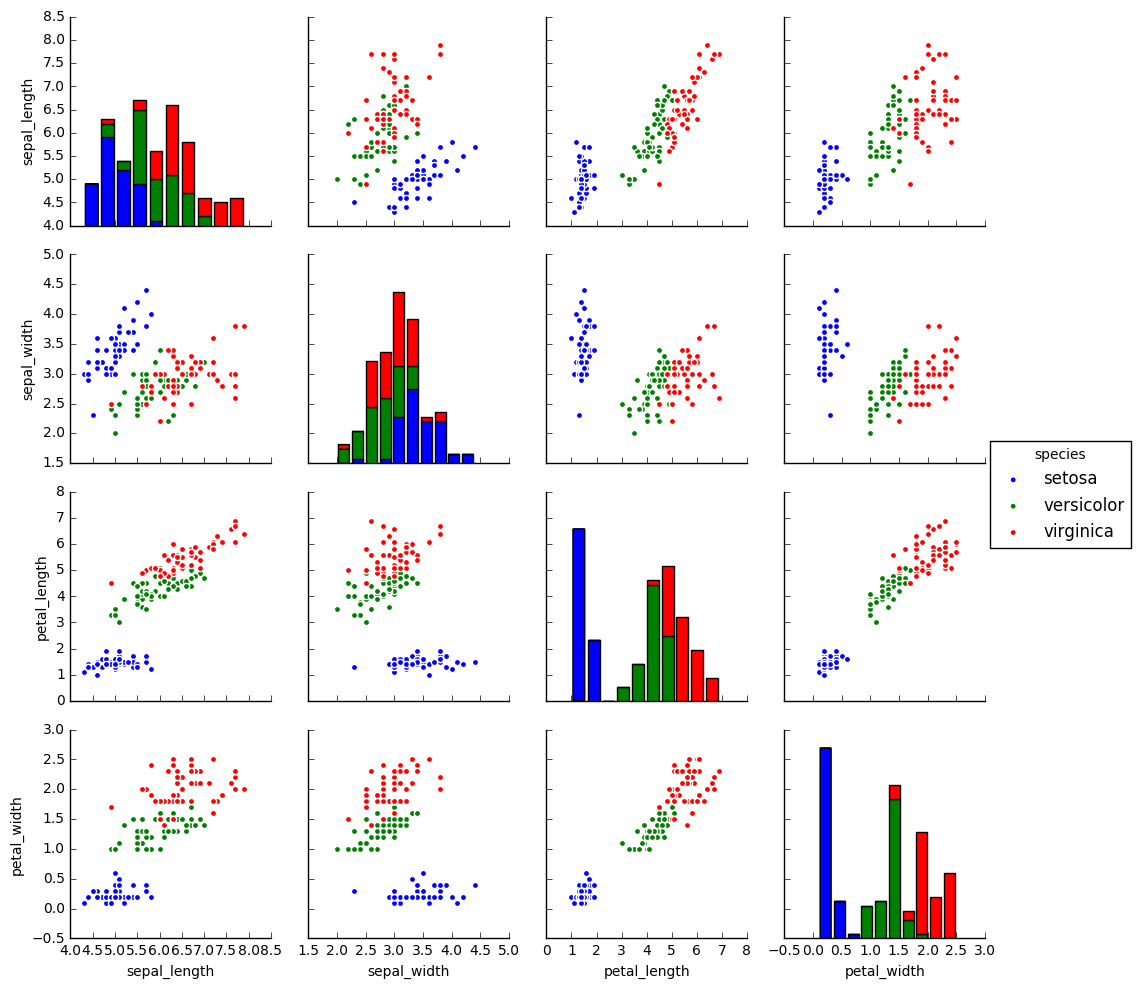

In [1]:
# Let's draw a matrix scatter plot for the Iris dataset 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

iris=sns.load_dataset('iris')
sns.pairplot(iris, hue='species')
plt.show()

%load_ext autoreload
%autoreload 2

Unfortunately it seems that the data is not linearly seperable. However, if we zoom into the plot with ("petal_length", "petal_width") we see that combining "versicolor" and "viginica" can give us what we are looking for.

In [2]:
# I now select "petal_length" and "petal_width" as my variables for the data.
iris_lin_sep = iris[['petal_width','petal_length', 'species']].copy()

# I will combine "versicolor" and "virginica" into one class.
iris_lin_sep.loc[iris_lin_sep['species']=='setosa', 'species'] = -1
iris_lin_sep.loc[iris_lin_sep['species']=='virginica', 'species'] = 1
iris_lin_sep.loc[iris_lin_sep['species']=='versicolor', 'species'] = 1

# From now on we're going to work with numpy arrays instead of dataframes
iris_lin_sep = iris_lin_sep.as_matrix()

Let's take a look at the scatter plot after we combine the labels in to two groups

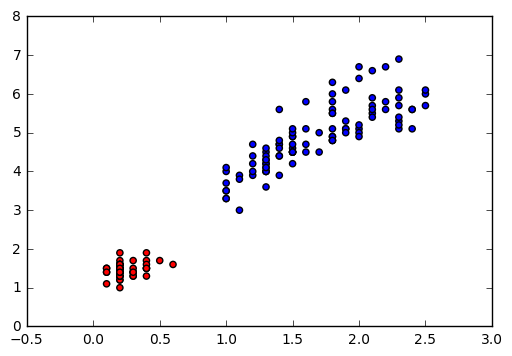

In [64]:
# Plot the combined data
colors = ['r' if label==-1 else 'b' for label in iris_lin_sep[:,2]]
plt.scatter(iris_lin_sep[:,0], iris_lin_sep[:,1], c=colors)
plt.show()

Now that we have a linearly seperable dataset, I'm going to divide the data into train, validation and test datasets. 

In [65]:
from sklearn.cross_validation import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(iris_lin_sep[:,:2], 
                                                            iris_lin_sep[:,2:3], 
                                                            test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, 
                                                y_val_test,
                                                test_size=0.5)
# Reshape y to be a 1D array
y_train = y_train.reshape(len(y_train))
y_val = y_val.reshape(len(y_val))
y_test = y_test.reshape(len(y_test))

Now we can start training the SVM model.

(w:[0.8235342560838588 1.2941252595603494], b:-3.78825757799)


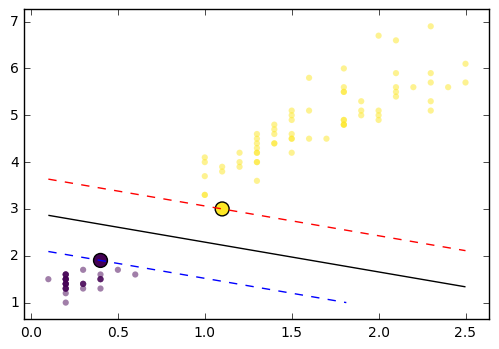

Error rate on the validataion data: 1.0


In [132]:
from svm import *

svm_fast = SVM(X_train, y_train, verbose=True)
svm_fast.train()
print "Error rate on the validataion data: {}".format(sum((svm_fast.predict(X_val) != y_val)) / float(len(y_val)))

I would like to also plot the objective function that we are trying to optimize in our SVM model. This is a great sanity check as we expect this to be monotonically increasing. 

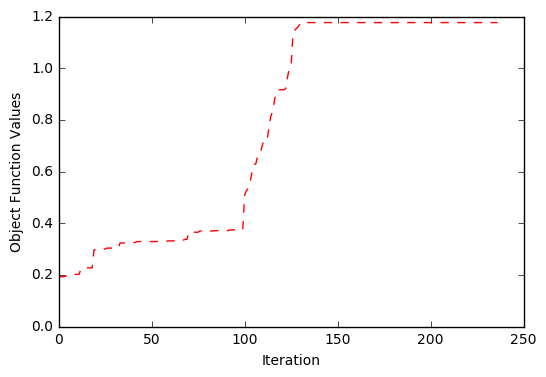

In [133]:
plt.ylabel("Object Function Values")
plt.xlabel("Iteration")
plt.plot(svm_fast.objective_func_values, 'r--')
plt.show()